In [1]:
import warnings; warnings.simplefilter('ignore')

import os
import time
import torch
import itertools
import random
import torch.nn as nn
from cell import graph_utils, utils, plot_utils
from cell.Word2vec import prepare_vocab, dataloader, wv
from stellargraph import StellarGraph
from torch.nn import functional as F
from stellargraph.data import BiasedRandomWalk
import cell.BiasedDirectedWeightedWalk as BDWW
from stellargraph import StellarDiGraph
import seaborn as sns
from IPython.display import Image
from cell import coupled_wv as cp


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Create an undirected graph

In [3]:
edges = pd.DataFrame([[1, 3, 1],
                     [1, 4, 1],
                     [2, 3, 1],
                     [3, 4, 1],
                     [4, 5, 1],
                     [2, 6, 1],
                     [6, 7, 1],
                     [3, 7, 1],
                     [4, 7, 1],
                     [7, 8, 1],
                     [5, 8, 1],
                     [6, 9, 1],
                     [9, 10, 1], 
                     [10, 11, 1], 
                     [7, 10, 1], 
                     [8, 11, 1]], columns=['source', 'target', 'weight'])

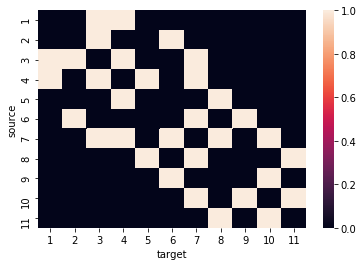

In [4]:
weight_mat = graph_utils.return_weight_mat_from_edgelist(edges, directed=False)
sns.heatmap(weight_mat)

In [6]:
# 1) for each layer first create a nx-Digraph
nxg = graph_utils.build_nx_graph(source_target_weight=edges, directed=False)

# 2) Create stellar Di graphs
sg = StellarGraph(nxg)

# 3) Initialize the walk and do the begin checks
rw = BiasedRandomWalk(sg)

nodes = sg.nodes()
walks = rw.run(nodes=nodes,
               length=10000,
               n=1,
               p=1,
               q=1,
               weighted=True)

In [15]:
walks = utils.read_list_of_lists_from_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/walk_undirected_footbal.csv")

### Basic Word2vec

In [8]:
data_loader, index_2_word, word_2_index, vocabulary = cp.return_basic_wv_dataloader(walks)

lenght of vocabulary: 11
a node called pad is added for padding and its index is zero
a node called pad is added for padding and its index is zero
There are 439934 pairs of target and context words


In [7]:
for idx, (target, context) in enumerate(data_loader):
    print("yes")
    break

yes


In [8]:
index_2_word

{0: 'pad',
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11}

In [9]:
model, loss = cp.run_basic_wv(vocabulary=vocabulary, 
                              embedding_size=2, 
                              learning_rate=0.001, 
                              n_epochs=50, 
                              data_loader=data_loader, 
                              device=device)

epoch: 1/50, loss:2.5486
epoch: 10/50, loss:2.0469
epoch: 19/50, loss:2.0181
epoch: 28/50, loss:2.0153
epoch: 37/50, loss:2.0143
epoch: 46/50, loss:2.0139


Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


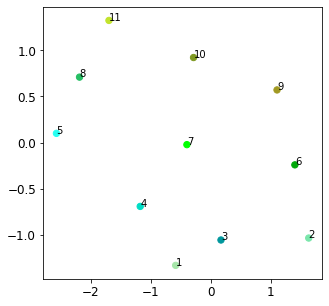

In [11]:
from cell import analysis, plot_utils
cldf = utils.read_visp_npp_cldf()
vectors = model.embeddings.weight.detach().numpy()
vectors = pd.DataFrame(vectors, columns=["Z0", "Z1"], index=index_2_word.values())
vectors.index.name = "cluster_id"
vectors.index = vectors.index.astype('str')
vectors = vectors.merge(cldf, on='cluster_id')

fig = plot_utils.plot_embedding(vectors, plot_dim=2, plot_size=(5,5), annotation=True)

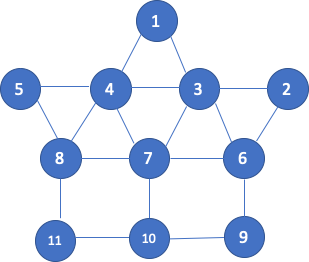

In [10]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/footbal_4_3_3.png")

In [35]:
print([index_2_word[i.item()] for i in target][0:10])
print([index_2_word[i.item()] for i in context][0:10])

[1, 1, 3, 3, 3, 4, 4, 4, 4, 3]
[3, 4, 1, 4, 3, 1, 3, 3, 1, 3]


In [12]:
walks[0]

[1, 3, 1, 4, 3, 2, 6, 9, 10, 7, 6, 2]

In [11]:
print([index_2_word[i.item()] for i in target][0:10])
print([index_2_word[i.item()] for i in context][0:10])

[3, 1, 1, 1, 4, 1, 3, 4, 3, 3]
[1, 1, 3, 3, 3, 1, 1, 1, 1, 4]


The embedding we found makes a lot of sense as the real graph is shown in the figure.

### Now we must be able to generate the same embedding with the coupled word2vec if the arms are independent
Meaning that we are not exchanging the coordinates.

In [29]:
# receiver_tuples

In [37]:
arm_keys, data_loader, index_2_word, word_2_index, vocabulary = cp.return_dataloader_coupled(corpus=walks, 
                                                                                             padding=True, 
                                                                                             window=2, 
                                                                                             shuffle=True, 
                                                                                             batch_size=2000)

a node called pad is added for padding and its index is zero
a node called pad is added for padding and its index is zero


In [41]:
for batch_idx, all_data in enumerate(data_loader):
    target_data = [data[1].to(device) for data in all_data]
    context_data = [data[0].to(device) for data in all_data]
    break

In [43]:
context_data

[tensor([ 2,  6,  2,  ...,  1, 10, 10]),
 tensor([ 2,  6,  2,  ...,  1, 10, 10])]

In [42]:
target_data

[tensor([ 9,  8, 11,  ..., 10,  1,  3]), tensor([1, 5, 2,  ..., 2, 3, 5])]

In [38]:
cp_model, cp_loss = cp.run_coupled(data_loader=data_loader, 
                                   vocab_size=12, 
                                   embedding_size=2, 
                                   learning_rate=0.001, 
                                   n_epochs=50, 
                                   n_arm=2, 
                                   batch_size=2000, 
                                   device=device, 
                                   arm_keys=arm_keys)

epoch: 1/50, loss:5.0174
epoch: 10/50, loss:4.2643
epoch: 19/50, loss:4.0585
epoch: 28/50, loss:4.0380
epoch: 37/50, loss:4.0340
epoch: 46/50, loss:4.0312


Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


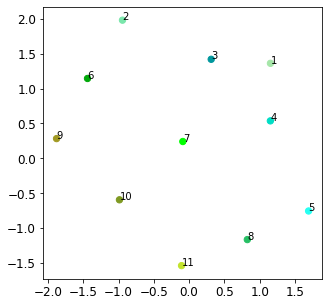

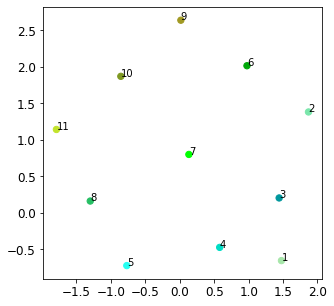

In [39]:
from cell import analysis, plot_utils
cldf = utils.read_visp_npp_cldf()
vectors = cp_model.embeddings[0].weight.detach().numpy()
vectors = pd.DataFrame(vectors, columns=["Z0", "Z1"], index=index_2_word.values())
vectors.index.name = "cluster_id"
vectors.index = vectors.index.astype('str')
vectors = vectors.merge(cldf, on='cluster_id')

fig = plot_utils.plot_embedding(vectors, plot_dim=2, plot_size=(5,5), annotation=True)

vectors = cp_model.embeddings[1].weight.detach().numpy()
vectors = pd.DataFrame(vectors, columns=["Z0", "Z1"], index=index_2_word.values())
vectors.index.name = "cluster_id"
vectors.index = vectors.index.astype('str')
vectors = vectors.merge(cldf, on='cluster_id')

fig = plot_utils.plot_embedding(vectors, plot_dim=2, plot_size=(5,5), annotation=True)

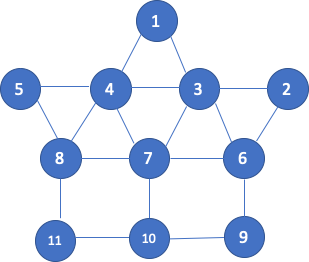

In [15]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/footbal_4_3_3.png")

### Now what if they exchange coordiantes

In [40]:
arm_keys, data_loader, index_2_word, word_2_index, vocabulary = cp.return_dataloader_coupled(corpus=walks, 
                                                                                             padding=True, 
                                                                                             window=2, 
                                                                                             shuffle=True, 
                                                                                             batch_size=2000)

a node called pad is added for padding and its index is zero
a node called pad is added for padding and its index is zero


In [49]:
cp_model, cp_loss = cp.run_coupled(data_loader=data_loader, 
                                   vocab_size=12, 
                                   embedding_size=2, 
                                   learning_rate=0.001, 
                                   n_epochs=100, 
                                   n_arm=2, 
                                   batch_size=2000, 
                                   device=device, 
                                   arm_keys=arm_keys)

epoch: 1/100, loss:5.0855
epoch: 10/100, loss:2.7026
epoch: 19/100, loss:2.2187
epoch: 28/100, loss:2.0466
epoch: 37/100, loss:1.9721
epoch: 46/100, loss:1.9417
epoch: 55/100, loss:1.9274
epoch: 64/100, loss:1.9202
epoch: 73/100, loss:1.9162
epoch: 82/100, loss:1.9136
epoch: 91/100, loss:1.9121
epoch: 100/100, loss:1.9108


Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


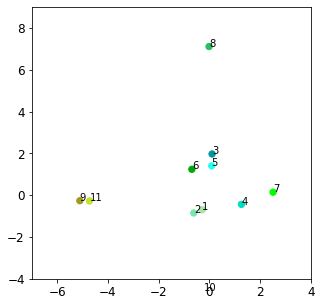

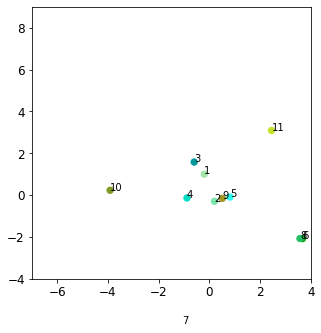

In [53]:
cldf = utils.read_visp_npp_cldf()
vectors = cp_model.embeddings[0].weight.detach().numpy()
vectors = pd.DataFrame(vectors, columns=["Z0", "Z1"], index=index_2_word.values())
vectors.index.name = "cluster_id"
vectors.index = vectors.index.astype('str')
vectors = vectors.merge(cldf, on='cluster_id')

fig = plot_utils.plot_embedding(vectors, plot_dim=2, plot_size=(5,5), annotation=True, xlim=(-7,4), ylim=(-4,9))

vectors = cp_model.embeddings[1].weight.detach().numpy()
vectors = pd.DataFrame(vectors, columns=["Z0", "Z1"], index=index_2_word.values())
vectors.index.name = "cluster_id"
vectors.index = vectors.index.astype('str')
vectors = vectors.merge(cldf, on='cluster_id')

fig = plot_utils.plot_embedding(vectors, plot_dim=2, plot_size=(5,5), annotation=True, xlim=(-7,4), ylim=(-4,9))

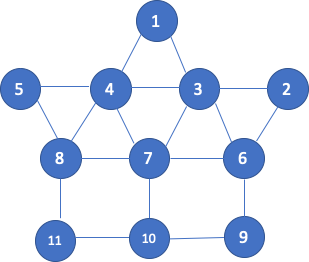

In [47]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/footbal_4_3_3.png")

# Directed graph 

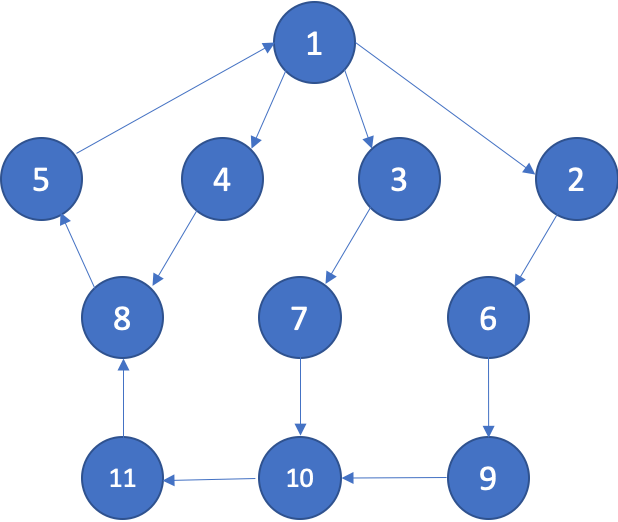

In [97]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/directed_footbal_4_3_3_v2.png", width=250, height=50)

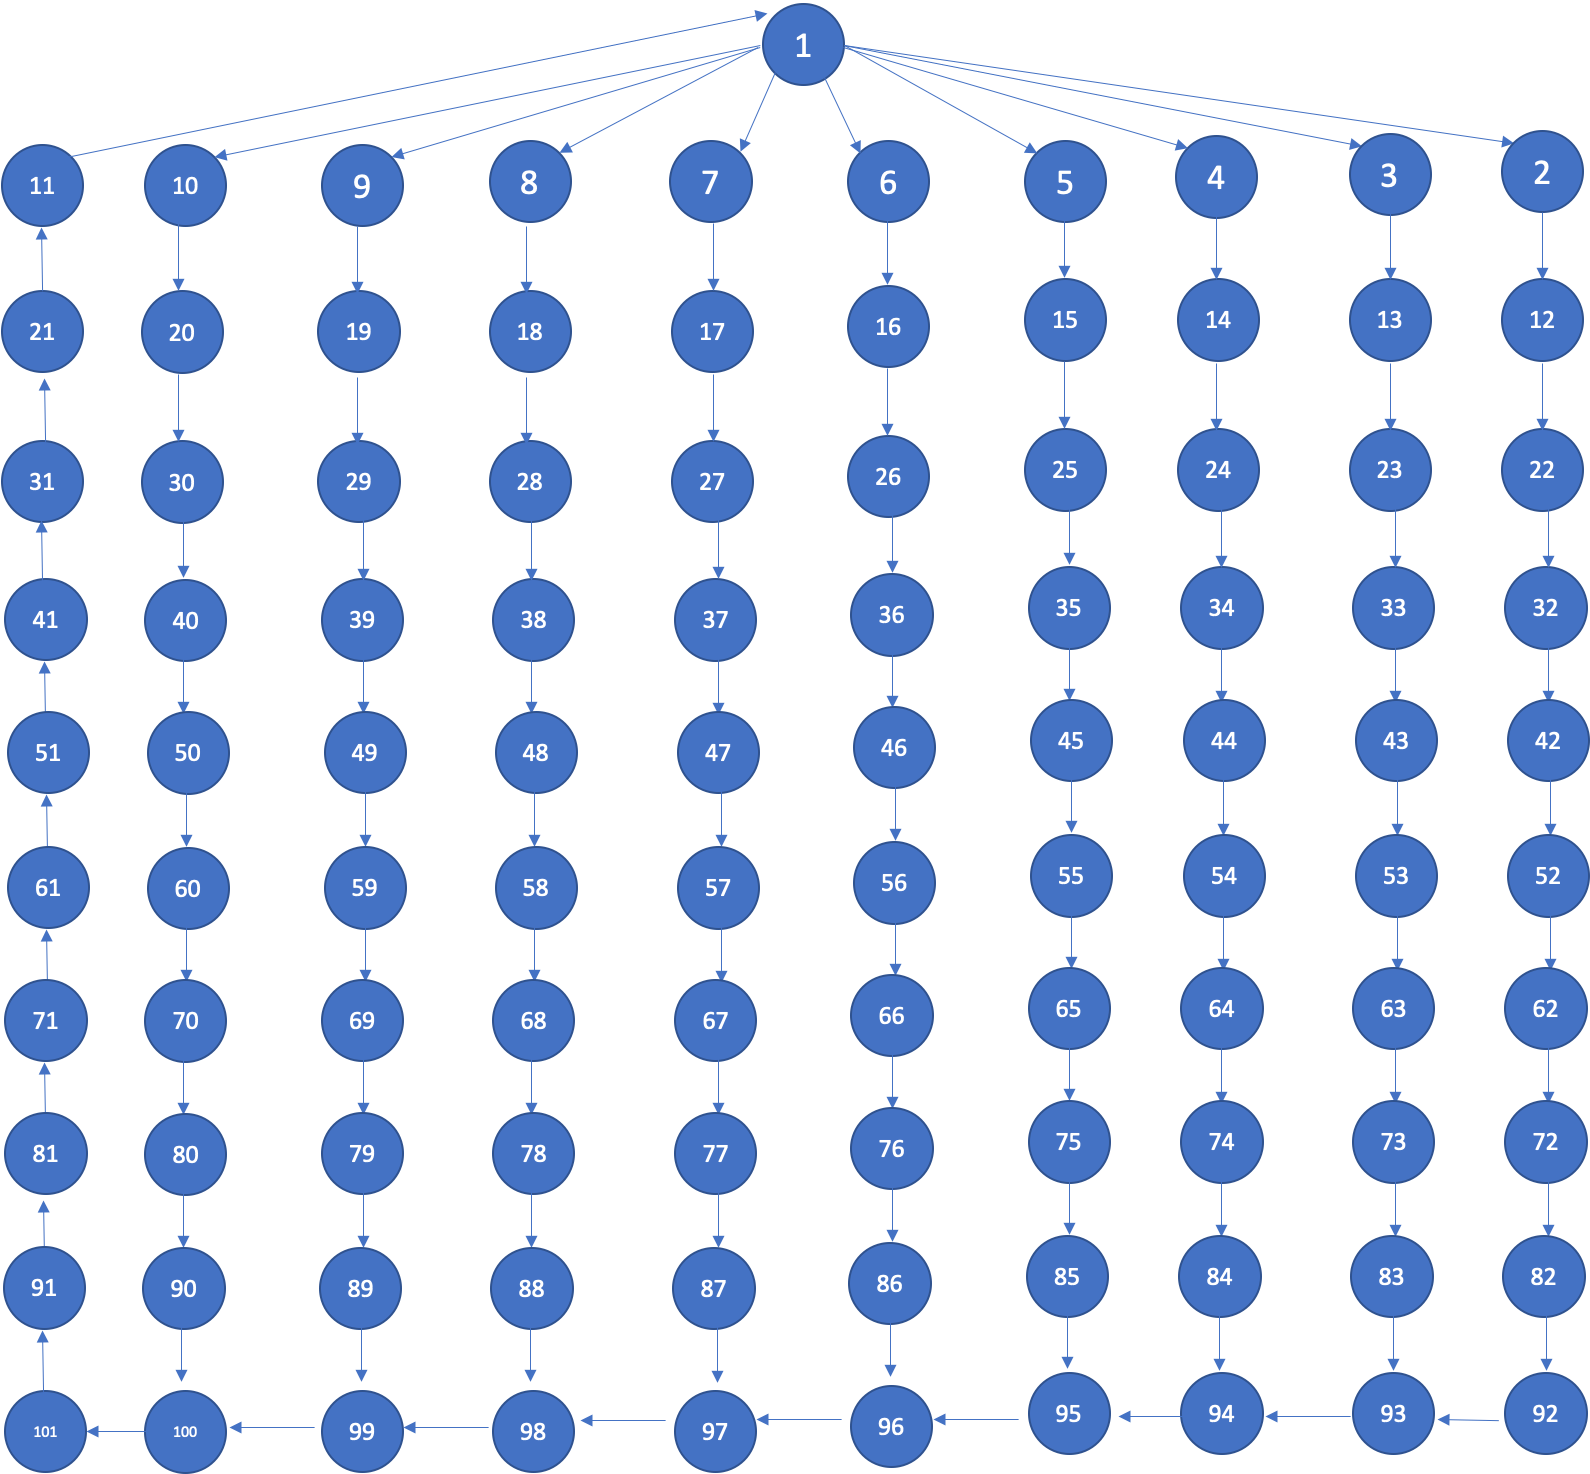

In [171]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/50nodes_directed.png", width=500, height=50)

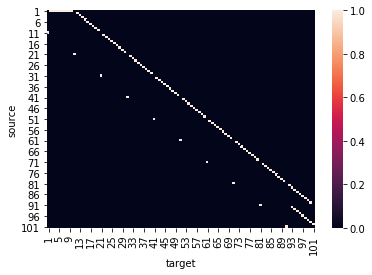

In [3]:
edges = pd.DataFrame([[1, 2, 1],
                      [1, 3, 1],
                      [1, 4, 1],
                      [2, 6, 1], 
                      [3, 7, 1], 
                      [4, 8, 1], 
                      [5, 1, 1], 
                      [6, 9, 1], 
                      [7, 10, 1], 
                      [8, 5, 1], 
                      [9, 10, 1], 
                      [10, 11, 1], 
                      [11, 8, 1]], columns=['source', 'target', 'weight'])

edges = pd.DataFrame(
    [[1, 2, 1], [1, 3, 1], [1, 4, 1], [1, 5, 1], [1, 6, 1], [1, 7, 1], [1, 8, 1], [1, 9, 1], [1, 10, 1], 
     [2, 12, 1], [3, 13, 1], [4, 14, 1], [5, 15, 1], [6, 16, 1], [7, 17, 1], [8, 18, 1], [9, 19, 1],[10, 20, 1],
     [12, 22, 1], [13, 23, 1], [14, 24, 1], [15, 25, 1], [16, 26, 1], [17, 27, 1], [18, 28, 1], [19, 29, 1],[20, 30, 1],
     [22, 32, 1], [23, 33, 1], [24, 34, 1], [25, 35, 1], [26, 36, 1], [27, 37, 1], [28, 38, 1], [29, 39, 1],[30, 40, 1],
     [32, 42, 1], [33, 43, 1], [34, 44, 1], [35, 45, 1], [36, 46, 1], [37, 47, 1], [38, 48, 1], [39, 49, 1],[40, 50, 1],
     [42, 52, 1], [43, 53, 1], [44, 54, 1], [45, 55, 1], [46, 56, 1], [47, 57, 1], [48, 58, 1], [49, 59, 1],[50, 60, 1],
     [52, 62, 1], [53, 63, 1], [54, 64, 1], [55, 65, 1], [56, 66, 1], [57, 67, 1], [58, 68, 1], [59, 69, 1],[60, 70, 1],
     [62, 72, 1], [63, 73, 1], [64, 74, 1], [65, 75, 1], [66, 76, 1], [67, 77, 1], [68, 78, 1], [69, 79, 1],[70, 80, 1],
     [72, 82, 1], [73, 83, 1], [74, 84, 1], [75, 85, 1], [76, 86, 1], [77, 87, 1], [78, 88, 1], [79, 89, 1],[80, 90, 1],
     [82, 92, 1], [83, 93, 1], [84, 94, 1], [85, 95, 1], [86, 96, 1], [87, 97, 1], [88, 98, 1], [89, 99, 1],[90, 100, 1],
     [92, 93, 1], [93, 94, 1], [94, 95, 1], [95, 96, 1], [96, 97, 1], [97, 98, 1], [98, 99, 1], [99, 100, 1], [100, 101, 1], 
     [101, 91, 1], [91, 81, 1], [81, 71, 1], [71, 61, 1], [61, 51, 1], [51, 41, 1], [41, 31, 1],[31, 21, 1],
     [21, 11, 1], [11, 1, 1]], columns=['source', 'target', 'weight'])

weight_mat = graph_utils.return_weight_mat_from_edgelist(edges, directed=True)
sns.heatmap(weight_mat)

In [4]:
# 1) for each layer first create a nx-Digraph
nxg = graph_utils.build_nx_graph(source_target_weight=edges, directed=True)

# 2) Create stellar Di graphs
sdg = StellarDiGraph(nxg)

BDWW.BeginWalk(sdg, begin_checks=True, weighted=True, directed=True)

rw = BDWW.BiasedDirectedRandomWalk(sdg,
                                   directed=True,
                                   weighted=True,
                                   begin_checks=False)

nodes = list(sdg.nodes())
walks = rw.run(nodes=nodes,
               length=100,
               n=100,
               p=1,
               q=1,
               weighted=True,
               directed=True)

Checking all the weights on all the edges!
Computing the node importance!


In [5]:
arm_keys, data_loader, index_2_word, word_2_index, vocabulary = cp.return_dataloader_coupled(corpus=walks, 
                                                                                             padding=True, 
                                                                                             window=2, 
                                                                                             shuffle=True, 
                                                                                             batch_size=2000)

a node called pad is added for padding and its index is zero
a node called pad is added for padding and its index is zero


In [6]:
cp_model, cp_loss = cp.run_coupled(data_loader=data_loader, 
                                   vocab_size=102, 
                                   embedding_size=2, 
                                   learning_rate=0.001, 
                                   n_epochs=100, 
                                   n_arm=2, 
                                   batch_size=2000, 
                                   device=device, 
                                   arm_keys=arm_keys)

epoch: 1/100, loss:7.8169
epoch: 10/100, loss:3.1519
epoch: 19/100, loss:2.6527
epoch: 28/100, loss:2.4642
epoch: 37/100, loss:2.3617
epoch: 46/100, loss:2.2965
epoch: 55/100, loss:2.2498
epoch: 64/100, loss:2.2129
epoch: 73/100, loss:2.1839
epoch: 82/100, loss:2.1604
epoch: 91/100, loss:2.1406
epoch: 100/100, loss:2.1239


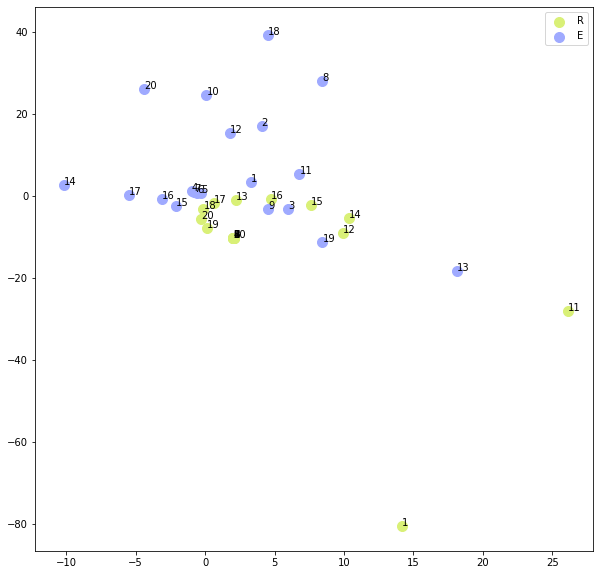

In [15]:
R = cp_model.embeddings[0].weight.detach().numpy()
R = pd.DataFrame(R, columns=["Z0", "Z1"], index=index_2_word.values())
R = R[1:]
R.index = R.index.astype('str')

E = cp_model.embeddings[1].weight.detach().numpy()
E = pd.DataFrame(E, columns=["Z0", "Z1"], index=index_2_word.values())
E = E[1:]
E.index = E.index.astype('str')


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
tmp_R = R[0:20]
ax.scatter(tmp_R['Z0'], tmp_R['Z1'], color='#D9F077', s=100, label='R')
for j, txt in enumerate(tmp_R.index.tolist()):
    ax.text(tmp_R['Z0'][j], tmp_R["Z1"][j], txt, size=10)

tmp_E = E[0:20]
ax.scatter(tmp_E['Z0'], tmp_E['Z1'], color='#9FAAFF', s=100, label='E')
for j, txt in enumerate(tmp_E.index.tolist()):
    ax.text(tmp_E['Z0'][j], tmp_E["Z1"][j], txt, size=10)
    
ax.legend()

In [11]:
R[0:10]

,Z0,Z1
1,14.191716,-80.613380
2,2.041332,-10.205426
3,2.044900,-10.201381
4,2.051591,-10.195123
5,2.047312,-10.202458
6,2.041503,-10.208020
7,2.034920,-10.207006
8,2.059932,-10.189387
9,2.054922,-10.198709
10,2.043318,-10.203816


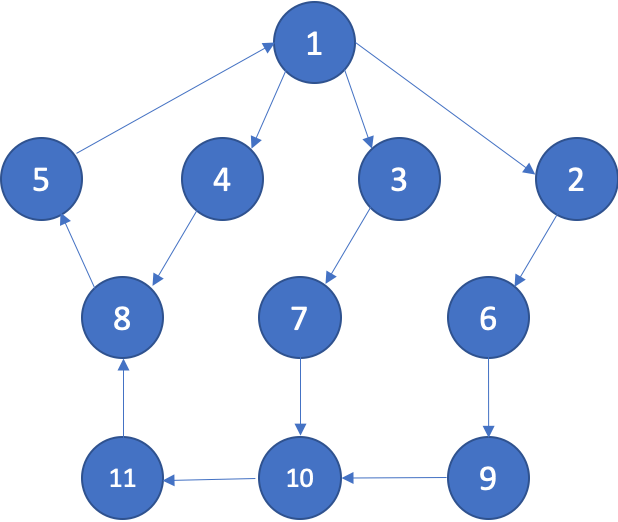

In [133]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/directed_footbal_4_3_3_v2.png", width=250, height=50)

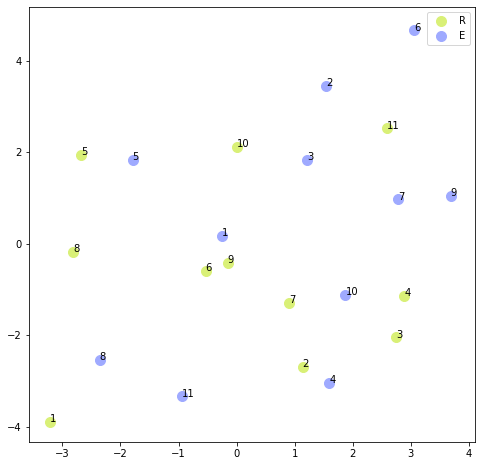

In [44]:
R = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/R.csv", index_col="Unnamed: 0")
E = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/E.csv", index_col="Unnamed: 0")
E.index = E.index.astype('str')
R.index = R.index.astype('str')

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(R['Z0'], R['Z1'], color='#D9F077', s=100, label='R')
for j, txt in enumerate(R.index.tolist()):
    ax.text(R['Z0'][j], R["Z1"][j], txt, size=10)

ax.scatter(E['Z0'], E['Z1'], color='#9FAAFF', s=100, label='E')
for j, txt in enumerate(E.index.tolist()):
    ax.text(E['Z0'][j], E["Z1"][j], txt, size=10)
    
ax.legend()